# Age recognition 

**Authors**: Richard Šléher, Tomáš Majerník

**Dataset**: https://www.kaggle.com/datasets/arashnic/faces-age-detection-dataset/code?select=train.csv

In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import wandb
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from summarytools import dfSummary
from timm import create_model
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms

warnings.filterwarnings("ignore")


c:\Users\risko\miniconda3\envs\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Hyperparameters

In [2]:
IMAGE_SIZE = 128
batch_size = 256
num_epochs = 50

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


## EDA

In [4]:
data = pd.read_csv("data/train.csv")

In [5]:
dfSummary(data)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,ID[object],1. 9896.jpg2. 377.jpg3. 7038.jpg4. 10812.jpg5. 11803.jpg6. 22630.jpg7. 9733.jpg8. 6149.jpg9. 10025.jpg10. 14939.jpg11. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)19,896 (99.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Class[object],1. MIDDLE2. YOUNG3. OLD,"10,804 (54.3%)6,706 (33.7%)2,396 (12.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmUlEQVR4nO3bMWrjYBSF0adBhKSRMAYvxouYxc4itBtjrCIJaZQiXYY4jeZK8+ecFTybDxsZ325ZloKEX1sfwM/RVdVTVT1sfUhD3pZledn6iD3qj8fj72EYDlsf0op5nq9d1/0R3N/6YRgO5/P5ZRzH162P+d/dbrfHaZoOl8vloarE9klfVTWO4+vpdHre+phGPG19wF55QCBGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGTF/18T+srQ9pgffxvn6e5+s0TYfyP6xVzPN8raq3re/YIxuE9dkgfKEz5SOlxU82nyw71dy6yrppv5paV1k37VuL6ypP1TvlR11ixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxDS1rmrldbSquXWVddN+2SAQY11FjAcEYtb+GvUVxpdWnfKZ0XHPalM+Mzq+s/aUr4mfT/g3PCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2a1KZ8ZHd9ZdcpnRsc9NgjEmPIR8w5KvKNKilfZywAAAABJRU5ErkJggg=="">",0(0.0%)


<Axes: xlabel='Class', ylabel='Count'>

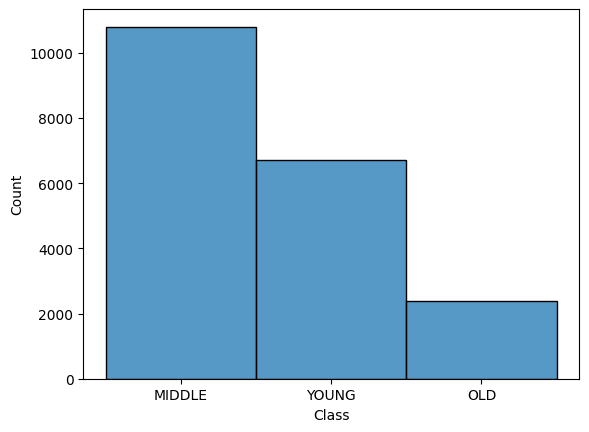

In [6]:
sns.histplot(data["Class"])

Máme nepomer tried, čiže pri trénovaní modelu sme nastavili rozdielne weighty pre triedy aby sme "vyrovnali" tento nepomer.

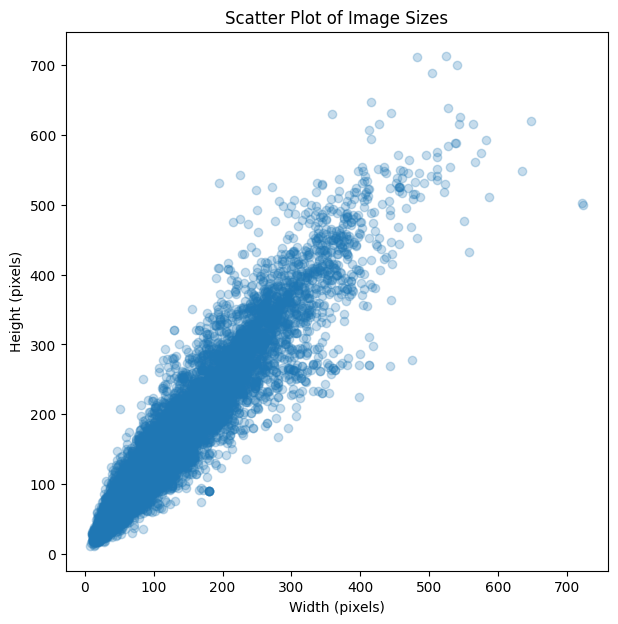

In [7]:
image_sizes = []

for img_id in data["ID"]:
    img_path = os.path.join("data/train/", img_id)
    try:
        with Image.open(img_path) as img:
            image_sizes.append(img.size)
    except Exception as e:
        print(f"Error processing file {img_path}: {e}")

if image_sizes:
    widths, heights = zip(*image_sizes, strict=False)

    # Create a scatter plot
    plt.figure(figsize=(7, 7))
    plt.scatter(widths, heights, alpha=0.25)
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")
    plt.title("Scatter Plot of Image Sizes")
    plt.show()
else:
    print("No image sizes were processed.")

Scatterplot distribúcie veľkostí obrázkov. Môžeme pozorovať, že obrázky majú veľký rozsah veľkostí.

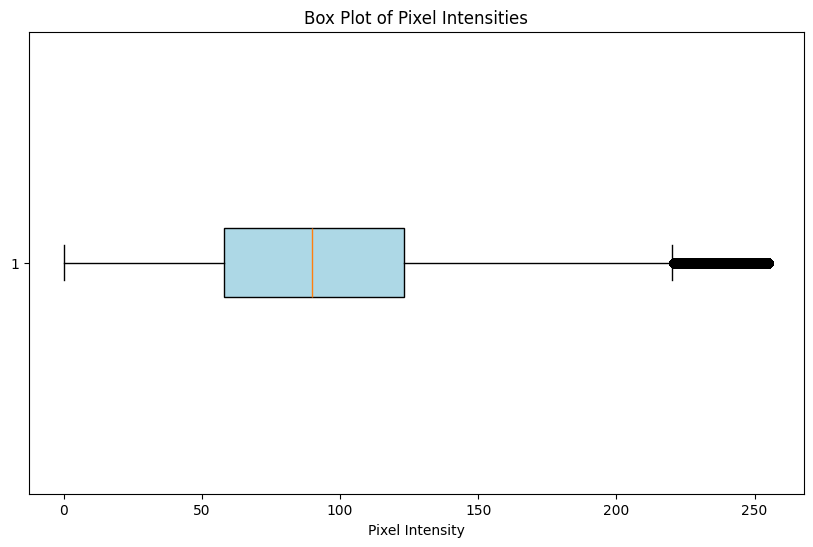

In [8]:
pixel_intensities = []

for img_id in data["ID"]:
    img_path = os.path.join("data/train/", img_id)
    try:
        with Image.open(img_path) as img:
            grayscale_img = img.convert("L")
            pixel_intensities.append(np.array(grayscale_img).flatten())
    except Exception as e:
        print(f"Error processing file {img_path}: {e}")

if pixel_intensities:
    combined_intensities = np.concatenate(pixel_intensities)

    plt.figure(figsize=(10, 6))
    plt.boxplot(
        combined_intensities,
        vert=False,
        patch_artist=True,
        boxprops={"facecolor": "lightblue"},
    )
    plt.xlabel("Pixel Intensity")
    plt.title("Box Plot of Pixel Intensities")
    plt.show()
else:
    print("No pixel intensities were processed.")

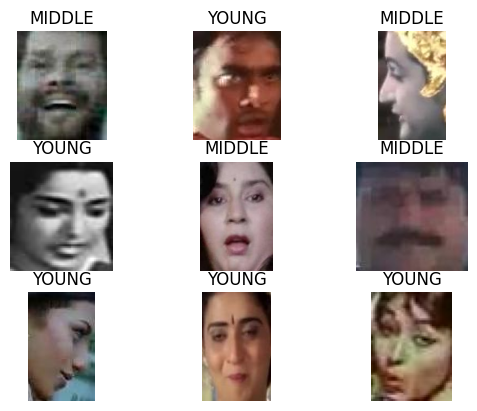

In [9]:
fig = plt.figure()

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread("data/train/" + data.iloc[i]["ID"])
    plt.imshow(img)
    plt.title(data.iloc[i]["Class"])
    plt.axis("off")

plt.show()

In [10]:
X = data["ID"]
y = data["Class"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, shuffle=True, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, shuffle=True, random_state=42
)

In [11]:
X_train_df = pd.DataFrame(X_train)
X_train_df["Target"] = y
dfSummary(X_train_df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,ID[object],1. 1408.jpg2. 18855.jpg3. 13392.jpg4. 3167.jpg5. 8817.jpg6. 7576.jpg7. 20124.jpg8. 21497.jpg9. 10765.jpg10. 8691.jpg11. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)13,924 (99.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Target[object],1. MIDDLE2. YOUNG3. OLD,"7,563 (54.3%)4,694 (33.7%)1,677 (12.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmUlEQVR4nO3bMWrjYBSF0adBhKSRMAYvxouYxc4itBtjrCIJaZQiXYY4jeZK8+ecFTybDxsZ325ZloKEX1sfwM/RVdVTVT1sfUhD3pZledn6iD3qj8fj72EYDlsf0op5nq9d1/0R3N/6YRgO5/P5ZRzH162P+d/dbrfHaZoOl8vloarE9klfVTWO4+vpdHre+phGPG19wF55QCBGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGTF/18T+srQ9pgffxvn6e5+s0TYfyP6xVzPN8raq3re/YIxuE9dkgfKEz5SOlxU82nyw71dy6yrppv5paV1k37VuL6ypP1TvlR11ixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxDS1rmrldbSquXWVddN+2SAQY11FjAcEYtb+GvUVxpdWnfKZ0XHPalM+Mzq+s/aUr4mfT/g3PCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2a1KZ8ZHd9ZdcpnRsc9NgjEmPIR8w5KvKNKilfZywAAAABJRU5ErkJggg=="">",0(0.0%)


In [12]:
X_test_df = pd.DataFrame(X_test)
X_test_df["Target"] = y_test
dfSummary(X_test_df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,ID[object],1. 9310.jpg2. 19933.jpg3. 18499.jpg4. 25215.jpg5. 18971.jpg6. 18315.jpg7. 18431.jpg8. 21207.jpg9. 4922.jpg10. 20882.jpg11. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)2,976 (99.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADQklEQVR4nO3cwWkbYRRG0TdCJPZGQghUQtKDisg2HauINGGkReJ44yyCS8gdmJxTwb+48BDMp+X9/X2gsFv7Afw/xEZGbGTERkZsZMRGRmxkxEZGbGTERma3LMvXZVme1n4I27ebmS8z83nth7B9zigZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkdnNzI+Z+b32Q9i+xb8YUXFGyYiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyIiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhklIzYyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhkls8zM88x8WvshbN7b/nw+fzscDqe1X8K2PR6Pl/3hcDhdr9dfx+Pxde0HsU33+/3pdrud9jMzx+Px9XK5/Fz7UWzasx8IZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZPYzfz8BWfshbNdHX8v5fP7u40n+tcfj8eKzcCpv1lVk/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiPzB0WpV2yec8bJAAAAAElFTkSuQmCC"">",0(0.0%)
2,Target[object],1. MIDDLE2. YOUNG3. OLD,"1,621 (54.3%)1,006 (33.7%)359 (12.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmUlEQVR4nO3bMWrjYBSF0adBhKSRMAYvxouYxc4itBtjrCIJaZQiXYY4jeZK8+ecFTybDxsZ325ZloKEX1sfwM/RVdVTVT1sfUhD3pZledn6iD3qj8fj72EYDlsf0op5nq9d1/0R3N/6YRgO5/P5ZRzH162P+d/dbrfHaZoOl8vloarE9klfVTWO4+vpdHre+phGPG19wF55QCBGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGTF/18T+srQ9pgffxvn6e5+s0TYfyP6xVzPN8raq3re/YIxuE9dkgfKEz5SOlxU82nyw71dy6yrppv5paV1k37VuL6ypP1TvlR11ixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxDS1rmrldbSquXWVddN+2SAQY11FjAcEYtb+GvUVxpdWnfKZ0XHPalM+Mzq+s/aUr4mfT/g3PCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2a1KZ8ZHd9ZdcpnRsc9NgjEmPIR8w5KvKNKilfZywAAAABJRU5ErkJggg=="">",0(0.0%)


In [13]:
X_val_df = pd.DataFrame(X_val)
X_val_df["Target"] = y_val
dfSummary(X_val_df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,ID[object],1. 13314.jpg2. 955.jpg3. 2694.jpg4. 11877.jpg5. 22239.jpg6. 16197.jpg7. 6277.jpg8. 12321.jpg9. 1925.jpg10. 17901.jpg11. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)2,976 (99.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADQklEQVR4nO3cwWkbYRRG0TdCJPZGQghUQtKDisg2HauINGGkReJ44yyCS8gdmJxTwb+48BDMp+X9/X2gsFv7Afw/xEZGbGTERkZsZMRGRmxkxEZGbGTERma3LMvXZVme1n4I27ebmS8z83nth7B9zigZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkdnNzI+Z+b32Q9i+xb8YUXFGyYiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyIiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhklIzYyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhkls8zM88x8WvshbN7b/nw+fzscDqe1X8K2PR6Pl/3hcDhdr9dfx+Pxde0HsU33+/3pdrud9jMzx+Px9XK5/Fz7UWzasx8IZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZPYzfz8BWfshbNdHX8v5fP7u40n+tcfj8eKzcCpv1lVk/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiPzB0WpV2yec8bJAAAAAElFTkSuQmCC"">",0(0.0%)
2,Target[object],1. MIDDLE2. YOUNG3. OLD,"1,620 (54.3%)1,006 (33.7%)360 (12.1%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmUlEQVR4nO3bMWrjYBSF0adBhKSRMAYvxouYxc4itBtjrCIJaZQiXYY4jeZK8+ecFTybDxsZ325ZloKEX1sfwM/RVdVTVT1sfUhD3pZledn6iD3qj8fj72EYDlsf0op5nq9d1/0R3N/6YRgO5/P5ZRzH162P+d/dbrfHaZoOl8vloarE9klfVTWO4+vpdHre+phGPG19wF55QCBGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGTF/18T+srQ9pgffxvn6e5+s0TYfyP6xVzPN8raq3re/YIxuE9dkgfKEz5SOlxU82nyw71dy6yrppv5paV1k37VuL6ypP1TvlR11ixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxDS1rmrldbSquXWVddN+2SAQY11FjAcEYtb+GvUVxpdWnfKZ0XHPalM+Mzq+s/aUr4mfT/g3PCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2a1KZ8ZHd9ZdcpnRsc9NgjEmPIR8w5KvKNKilfZywAAAABJRU5ErkJggg=="">",0(0.0%)


In [14]:
image_data = []

for filename in os.listdir("./data/Train/"):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join("./data/Train/", filename)
        with Image.open(image_path) as image:
            image_data.append(
                {
                    "filename": filename,
                    "width": image.width,
                    "height": image.height,
                    "mode": image.mode,
                    "image": image,
                }
            )

        df = pd.DataFrame(image_data)

print(df.head())

    filename  width  height mode  \
0      0.jpg     68      69  RGB   
1      1.jpg    309     387  RGB   
2    100.jpg     98     168  RGB   
3  10000.jpg    115     137  RGB   
4  10001.jpg    105     162  RGB   

                                               image  
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...  


In [15]:
print("Width Stats:")
print(df["width"].describe())
print("Height Stats:")
print(df["height"].describe())

df["aspect_ratio"] = df["width"] / df["height"]
print("Aspect Ratio Stats:")
print(df["aspect_ratio"].describe())

print("Image Modes Count:")
print(df["mode"].value_counts())

Width Stats:
count    19906.000000
mean        99.010700
std         78.192463
min          8.000000
25%         43.000000
50%         75.000000
75%        129.000000
max        724.000000
Name: width, dtype: float64
Height Stats:
count    19906.000000
mean       125.467246
std         92.986340
min         11.000000
25%         59.000000
50%         97.000000
75%        163.000000
max        713.000000
Name: height, dtype: float64
Aspect Ratio Stats:
count    19906.000000
mean         0.782291
std          0.160539
min          0.246377
25%          0.687566
50%          0.775060
75%          0.861829
max          2.333333
Name: aspect_ratio, dtype: float64
Image Modes Count:
mode
RGB    19906
Name: count, dtype: int64


In [16]:
class AgeDataset(Dataset):
    def __init__(self, filenames: str, labels: str, transform: transforms.Compose=None) -> None:
        self.filenames = filenames
        self.labels = labels
        self.transform = transform
        self.label_mapping = {"YOUNG": 0, "MIDDLE": 1, "OLD": 2}

    def __len__(self) -> int:
        return len(self.filenames)

    def __getitem__(self, idx: int) -> tuple:
        img_name = os.path.join("data/train/", self.filenames.iloc[idx])
        image = Image.open(img_name).convert("RGB")
        label = self.labels.iloc[idx]
        label = self.label_mapping[label]

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)


train_dataset = AgeDataset(filenames=X_train, labels=y_train, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = AgeDataset(filenames=X_val, labels=y_val, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = AgeDataset(filenames=X_test, labels=y_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Dané transofrmácie sme vybrali na základe toho, že sa najviac hodia na normalizáciu násho typu obrázkov. Pretože, keď máme tvár nemôžeme ju otočiť napr. o 180 stupňov, lebo by si daný model mýlil oči s ústami napríklad. Horizontal flip a color jitter sú mierne transformácie aby sa model nenaučil iba na jeden uhol alebo jednu farbu pleti.

## 1. Custom CNN 

In [17]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(256 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, num_classes)

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout2(x)
        x = F.relu(self.fc4(x))
        s = self.dropout3(x)
        x = self.fc5(x)

        return x


In [18]:
model = CNN(in_channels=3, num_classes=3).to(device=device)

In [19]:
def evaluate(model: CNN, val_loader: DataLoader, criterion: nn.CrossEntropyLoss) -> tuple:
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average="weighted")
    recall = recall_score(all_labels, all_predictions, average="weighted")
    f1 = f1_score(all_labels, all_predictions, average="weighted")

    return val_loss / len(val_loader), accuracy, precision, recall, f1

In [20]:
class_weights = torch.tensor([1.0, 2.0, 3.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [21]:
wandb.init(
    project="age-recognition",
    name="Custom-LeNet-5",
    config={
        "model": "Custom-LeNet-5",
        "learning_rate": 1e-4,
        "batch_size": batch_size,
        "epochs": num_epochs
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: riso-sleher (riso-sleher-fiit-stu). Use `wandb login --relogin` to force relogin


In [22]:
# Training loop
model.to(device)

train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    val_loss, val_accuracy, precision, recall, f1 = evaluate(
        model, val_loader, criterion
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    train_accuracies.append(train_accuracy)

    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "f1": f1,
    })

    print(
        f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f},\
    Train Accuracy: {train_accuracy:.3f}, Val Accuracy: {val_accuracy:.3f},\
    Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}"
    )

    scheduler.step()

wandb.finish()

Epoch 1/50, Train Loss: 0.899, Val Loss: 0.832,    Train Accuracy: 0.548, Val Accuracy: 0.607,    Precision: 0.574, Recall: 0.607, F1: 0.527
Epoch 2/50, Train Loss: 0.788, Val Loss: 0.757,    Train Accuracy: 0.612, Val Accuracy: 0.655,    Precision: 0.655, Recall: 0.655, F1: 0.648
Epoch 3/50, Train Loss: 0.735, Val Loss: 0.737,    Train Accuracy: 0.644, Val Accuracy: 0.682,    Precision: 0.674, Recall: 0.682, F1: 0.663
Epoch 4/50, Train Loss: 0.713, Val Loss: 0.691,    Train Accuracy: 0.662, Val Accuracy: 0.676,    Precision: 0.687, Recall: 0.676, F1: 0.663
Epoch 5/50, Train Loss: 0.694, Val Loss: 0.680,    Train Accuracy: 0.671, Val Accuracy: 0.671,    Precision: 0.699, Recall: 0.671, F1: 0.654
Epoch 6/50, Train Loss: 0.672, Val Loss: 0.713,    Train Accuracy: 0.685, Val Accuracy: 0.696,    Precision: 0.702, Recall: 0.696, F1: 0.666
Epoch 7/50, Train Loss: 0.667, Val Loss: 0.659,    Train Accuracy: 0.692, Val Accuracy: 0.726,    Precision: 0.726, Recall: 0.726, F1: 0.723
Epoch 8/50, T

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1,▁▅▅▅▅▇▆▇▇▇▇▇███▇█▇▇█████████████▇███████
train_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇███████████████████████████
train_loss,█▆▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▄▄▆▆▆▆▇▇▇▆█▇▇▇▇▇▇▇▇███▇████▇██▇▇██▇▇█
val_loss,█▆▅▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
f1,0.75426
train_accuracy,0.76317
train_loss,0.53434
val_accuracy,0.75787


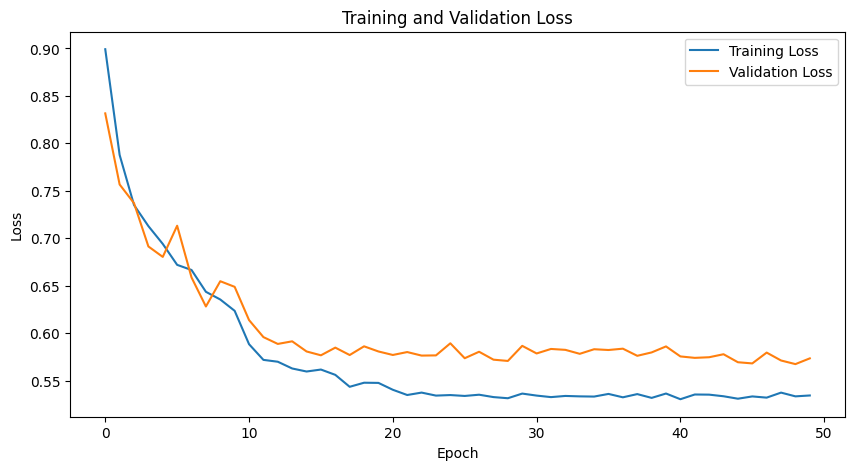

In [23]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

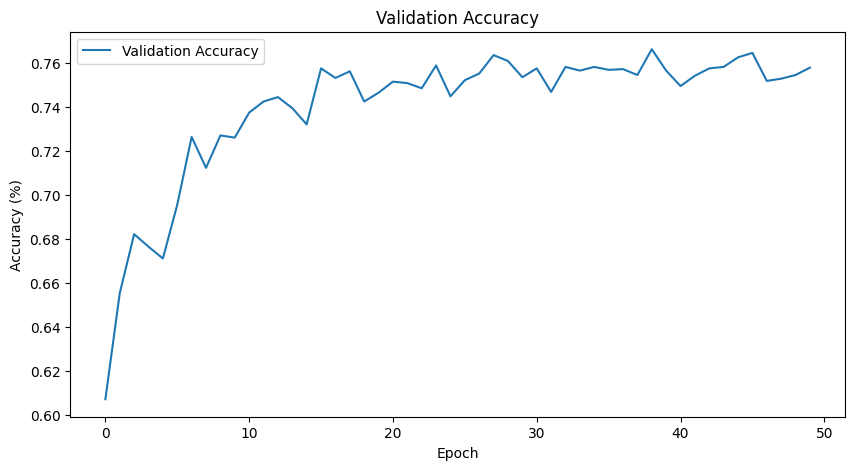

In [ ]:
# Plotting the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label="Validation Accuracy")
plt.plot(train_accuracies, label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy")
plt.show()

Model sa nám prestal zlepšovať približne od 20 epochu. Dôvodom môže byť, že sme model trocha preučili a nevedeli sme ho posunúť ďalej z dôvodu jeho jednoduchosti.

Model sa nám presta

## 2. Custom CNN

In [38]:
conv_base = create_model("xception", pretrained=True, num_classes=0)
conv_base.global_pool = nn.Identity()


class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.base_model = conv_base
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.batch_norm1 = nn.BatchNorm1d(2048)
        self.fc1 = nn.Linear(2048, 256)
        self.batch_norm2 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.batch_norm3 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)
        self.output = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.batch_norm1(x)
        x = F.relu(self.fc1(x))
        x = self.batch_norm2(x)
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.batch_norm3(x)
        x = self.dropout2(x)
        x = self.output(x)
        return F.softmax(x, dim=1)


num_classes = 3
model = CustomModel(num_classes=num_classes).to(device=device)

In [39]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
class_weights = torch.tensor([1.0, 2.0, 3.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [40]:
wandb.init(
    project="age-recognition",
    name="Custom-CNN_Xception",
    config={
        "model": "Custom-CNN_Xception",
        "learning_rate": 1e-4,
        "batch_size": batch_size,
        "epochs": num_epochs-40
    }
)

In [ ]:
train_losses = []
train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

for epoch in range(num_epochs-40):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    val_loss, val_accuracy, precision, recall, f1 = evaluate(
        model, val_loader, criterion
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    train_accuracies.append(train_accuracy)

    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "f1": f1,
    })

    print(
        f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f},\
    Train Accuracy: {train_accuracy:.3f}, Val Accuracy: {val_accuracy:.3f},\
    Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}"
    )

    scheduler.step()

wandb.finish()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
# Plotting the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label="Validation Accuracy")
plt.plot(train_accuracies, label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy")
plt.show()

## 3. Resnet-18 - pretrained

Source: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

In [ ]:
model_resnet = models.resnet18(pretrained=True)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 3)

model = model_resnet.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=1e-3)

In [ ]:
wandb.init(
    project="age-recognition",
    name="Resnet-18",
    config={
        "model": "Resnet-18",
        "learning_rate": 1e-3,
        "batch_size": batch_size,
        "epochs": num_epochs-40
    }
)

In [ ]:
train_losses = []
train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

for epoch in range(num_epochs-40):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    val_loss, val_accuracy, precision, recall, f1 = evaluate(
        model, val_loader, criterion
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    train_accuracies.append(train_accuracy)

    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "f1": f1,
    })

    print(
        f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f},\
    Train Accuracy: {train_accuracy:.3f}, Val Accuracy: {val_accuracy:.3f},\
    Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}"
    )

    scheduler.step()

wandb.finish()

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
# Plotting the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label="Validation Accuracy")
plt.plot(train_accuracies, label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy")
plt.show()

## Our face prediction using Resnet-18

In [ ]:
def predict_image(model, image_path, transform, device):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return predicted.item()

In [ ]:
image_paths = ["riso.jpg", "tomas.jpg"]
predictions = []

for image_path in image_paths:
    prediction = predict_image(model, image_path, transform, device)
    predictions.append(prediction)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
label_mapping = {0: "YOUNG", 1: "MIDDLE", 2: "OLD"}

for ax, image_path, prediction in zip(axes, image_paths, predictions, strict=False):
    image = plt.imread(image_path)
    ax.imshow(image)
    ax.set_title(f"Prediction: {label_mapping[prediction]}")
    ax.axis("off")

plt.show()